In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Анализ данных одной метрики одной БД 

In [2]:
import os
print(os.listdir("./input"))

['sample_dbsize1.csv', 'sample_dbsize2.csv', 'sample_dbtime1.csv', 'sample_dbtime2.csv', 'sample_redosize1.csv', 'tablespace_data.csv', 'tablespace_original.csv']


In [3]:
# import trends_process.py

NameError: name 'null' is not defined

In [111]:
sample = pd.read_csv('./input/sample_dbtime2.csv')
sample['rollup_timestamp'] = pd.to_datetime(sample['rollup_timestamp'])
sample = sample.set_index('rollup_timestamp')

In [112]:
sample.head()

,database,value
rollup_timestamp,,
2018-09-05,8d5018dd-ebbb-4cb1-9df2-b31fce70dd63,603.0
2018-09-06,8d5018dd-ebbb-4cb1-9df2-b31fce70dd63,552.0
2018-09-07,8d5018dd-ebbb-4cb1-9df2-b31fce70dd63,899.0
2018-09-08,8d5018dd-ebbb-4cb1-9df2-b31fce70dd63,921.0
2018-09-09,8d5018dd-ebbb-4cb1-9df2-b31fce70dd63,63.0


In [113]:
sample_s = sample['value']

In [114]:
sample_v = sample[['value']]

## Графики

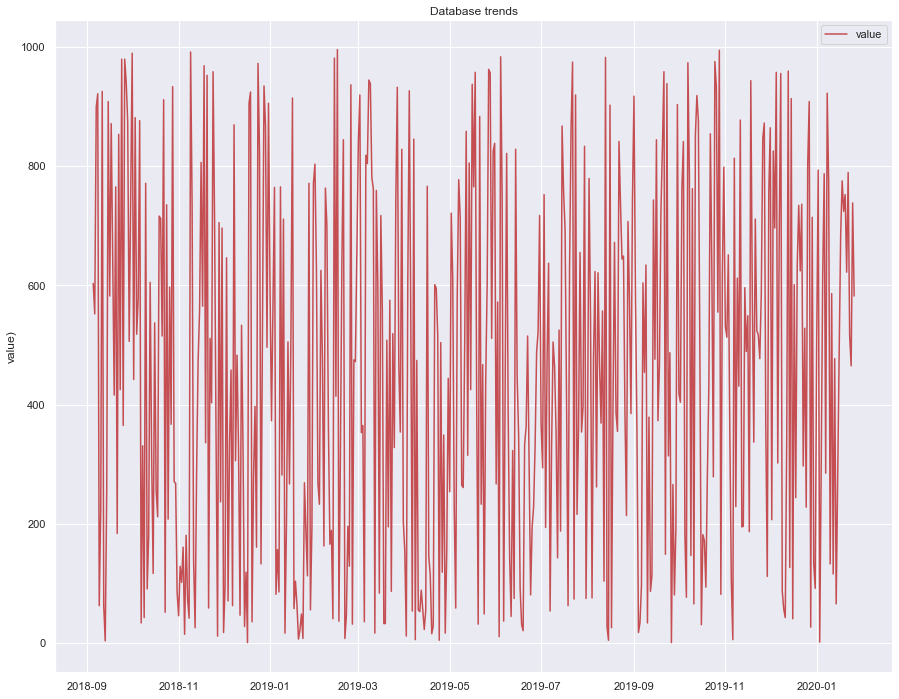

In [115]:
plt.figure(figsize=(15, 12))
plt.plot(sample.index, sample['value'], 'r-', label = 'value')
plt.title('Database trends')
plt.ylabel('value)');
plt.legend();
plt.show()

### Усреднение за месяц

In [116]:
sample_month = sample['value'].resample('MS').mean()

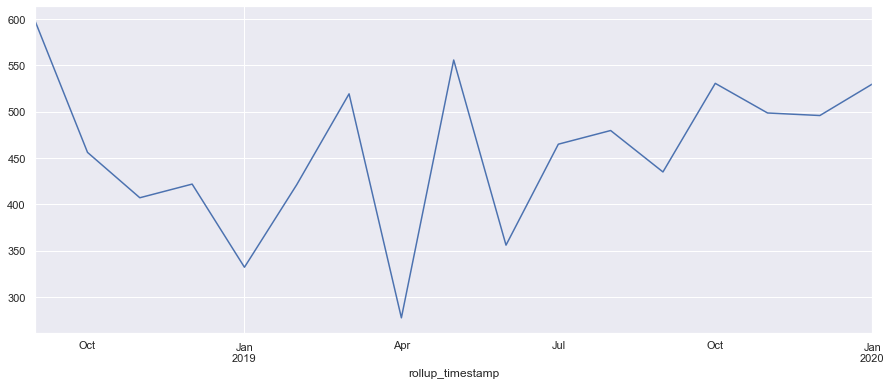

In [117]:
sample_month.plot(figsize=(15, 6))
plt.show()

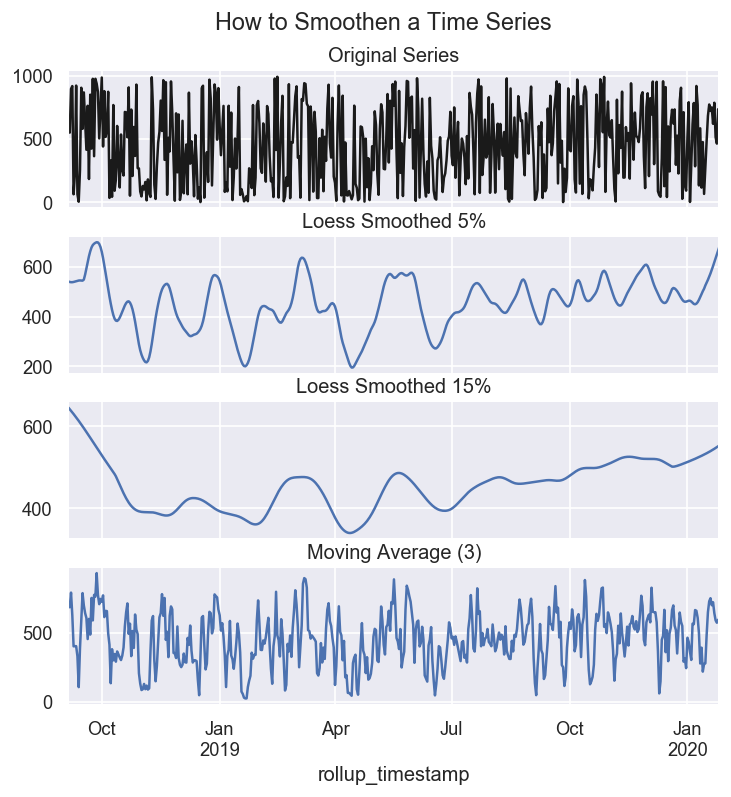

In [118]:
# сглаживания для наглядной визуализации
from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# бегущее среднее
sample_ma = sample.value.rolling(3, center=True, closed='both').mean()

# локальная регрессия (5% и 15%)
sample_loess_5 = pd.DataFrame(lowess(sample.value, np.arange(len(sample.value)), frac=0.05)[:, 1], index=sample.index, columns=['value'])
sample_loess_15 = pd.DataFrame(lowess(sample.value, np.arange(len(sample.value)), frac=0.15)[:, 1], index=sample.index, columns=['value'])

fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
sample['value'].plot(ax=axes[0], color='k', title='Original Series')
sample_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
sample_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
sample_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

Text(0.5, 1.0, 'detrended by subtracting the least squares fit')

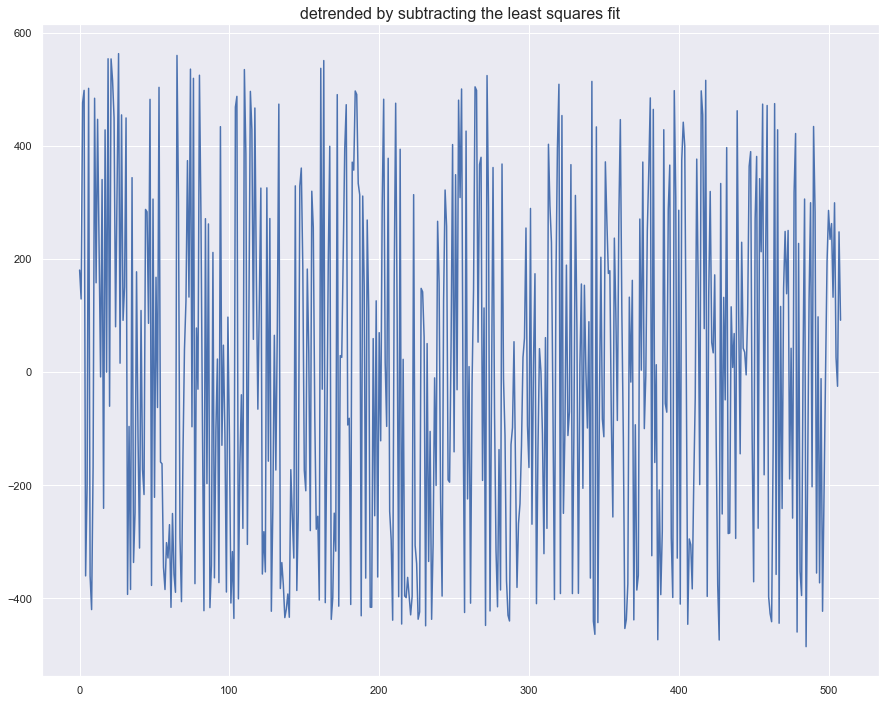

In [119]:
# с помощью scipy убираем компонент тренда, чтобы показать колебания
from scipy import signal
detrended = signal.detrend(sample.value.values)
plt.figure(figsize=(15, 12))
plt.plot(detrended)
plt.title('detrended by subtracting the least squares fit', fontsize=16)

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

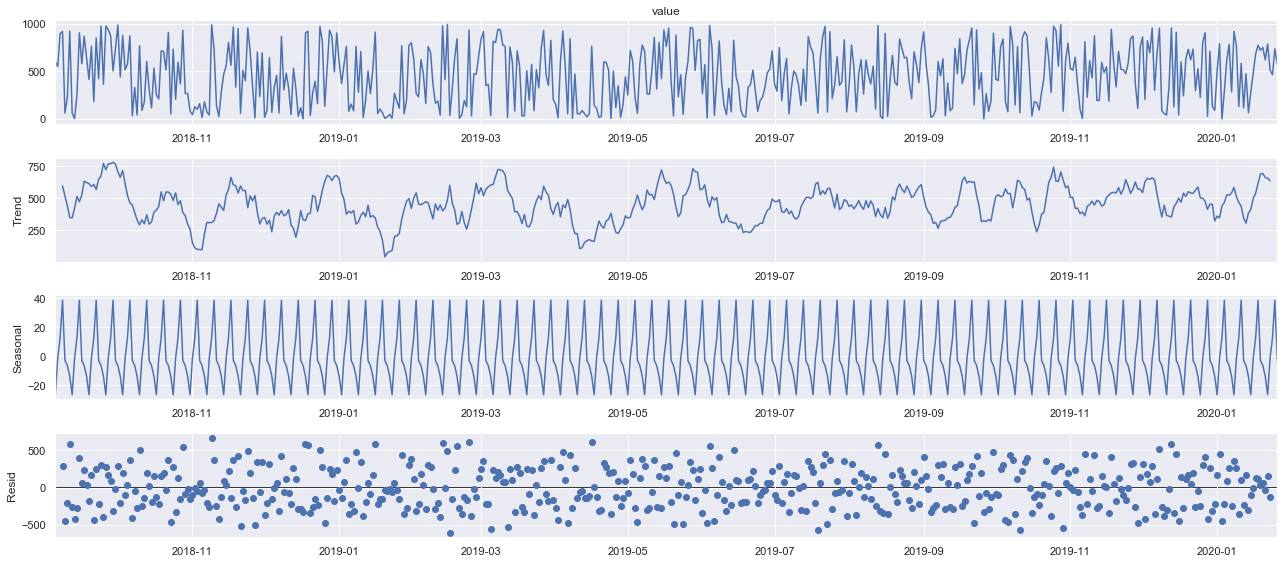

In [121]:
# извлечение тренда, сезонности и шума
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(sample_s, model='additive')
fig = decomposition.plot()
plt.show()

## Открытый курс машинного обучения. Тема 9. Анализ временных рядов с помощью Python
https://habr.com/ru/company/ods/blog/327242/

In [122]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt


In [123]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

plotly_df(sample_v, title = "Online users")

In [124]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(sample_v[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

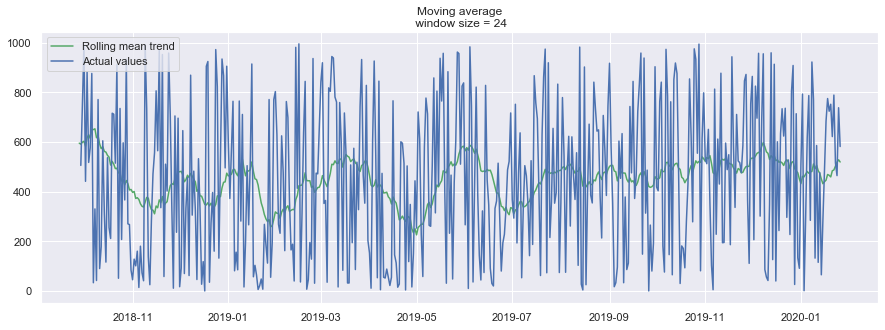

In [125]:
plotMovingAverage(sample_v, 24) # сглаживаем по дням

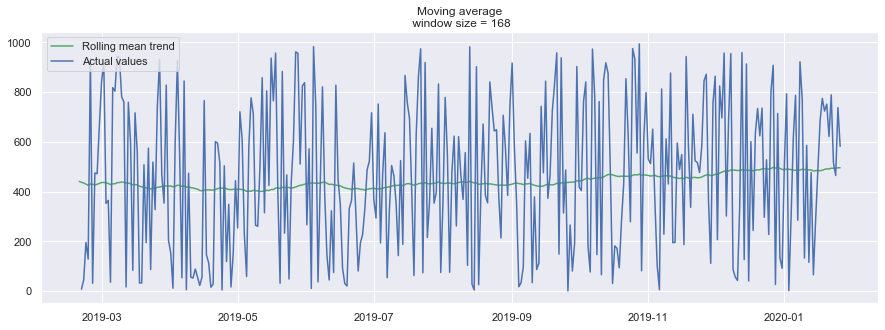

In [126]:
plotMovingAverage(sample_v, 24*7) # сглаживаем по неделям

In [127]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

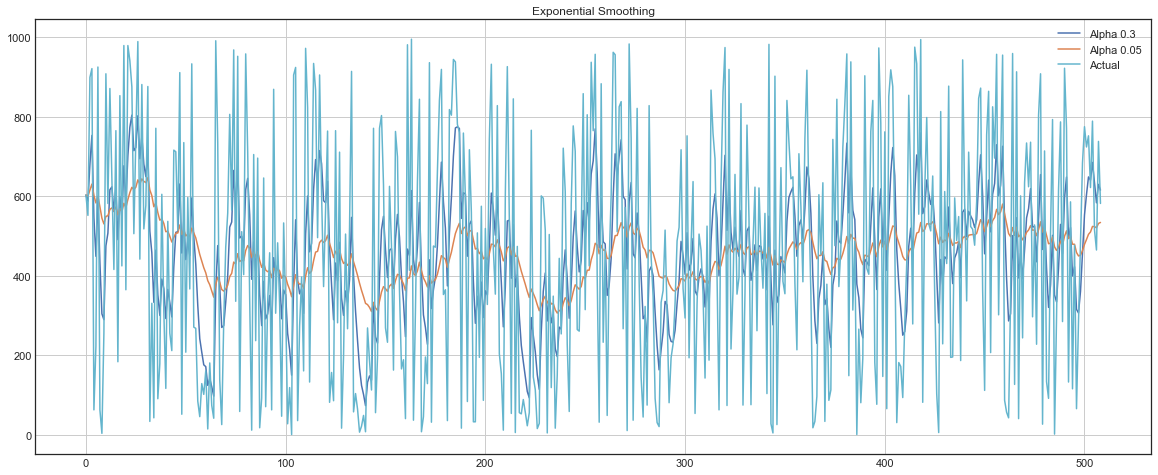

In [128]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(sample_v.value, alpha), label="Alpha {}".format(alpha))
    plt.plot(sample_v.value.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

In [129]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

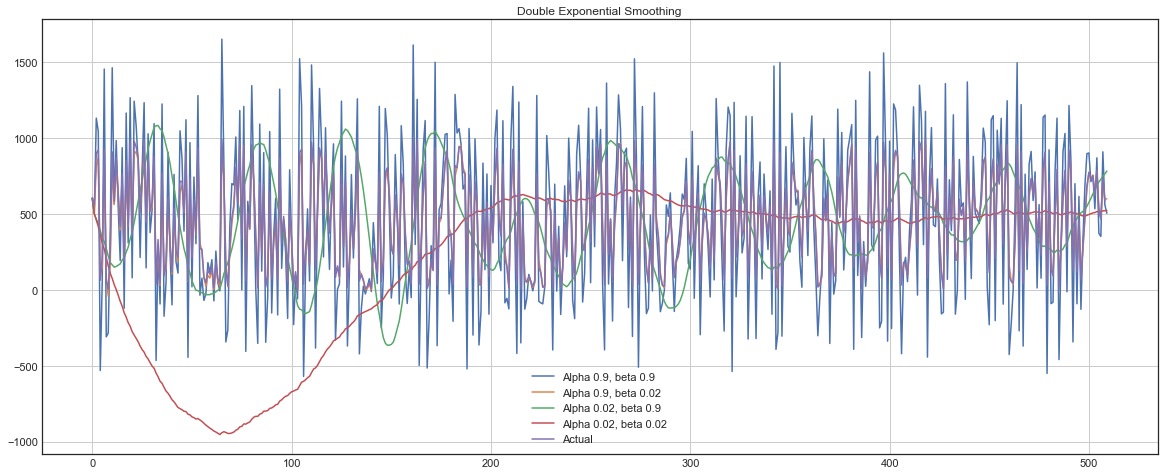

In [130]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(sample_v.value, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(sample_v.value.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

### кросс-валидации на временном ряду

In [131]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

In [132]:
%%time
data = sample_v.value[:-200] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

ZeroDivisionError: float division by zero

## Линейные и не очень модели на временных рядах

In [133]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [135]:
data = sample_v
data.columns = ["y"]

data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,y,hour,weekday,is_weekend
rollup_timestamp,,,,
2018-09-05,603.0,0,2,0
2018-09-06,552.0,0,3,0
2018-09-07,899.0,0,4,0
2018-09-08,921.0,0,5,1
2018-09-09,63.0,0,6,1


In [136]:
code_mean(data, 'weekday', "y")

{0: 448.34722222222223,
 1: 440.125,
 2: 429.43835616438355,
 3: 454.6027397260274,
 4: 471.7260273972603,
 5: 496.5342465753425,
 6: 453.73972602739724}

In [142]:
data

,y,hour,weekday,is_weekend
rollup_timestamp,,,,
2018-09-05,603.0,0,2,0
2018-09-06,552.0,0,3,0
2018-09-07,899.0,0,4,0
2018-09-08,921.0,0,5,1
2018-09-09,63.0,0,6,1
...,...,...,...,...
2020-01-22,789.0,0,2,0
2020-01-23,516.0,0,3,0
2020-01-24,465.0,0,4,0


In [137]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday)
    data["hour_average"] = map(code_mean(data[:test_index], 'hour', "y").get, data.hour)

    # выкидываем закодированные средними признаки 
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [143]:
prepareData(sample_v, lag_start=5, lag_end=20, test_size=0.15)

ValueError: Length mismatch: Expected axis has 4 elements, new values have 1 elements

In [138]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [139]:
%%time
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

NameError: name 'X_train' is not defined

## Prophet

In [144]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [145]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [146]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [147]:
plotly_df(sample_v, title='Posts on Medium (daily)')

In [148]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)


ModuleNotFoundError: No module named 'fbprophet'

## Autoregressive Integrated Moving Average
ARIMA models are denoted with the notation ARIMA(p, d, q) - three parameters account for seasonality, trend, and noise in data
https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

In [18]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [19]:
min = 9999
min_param = 0
min_param_seasonal = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sample_month,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min:
                min = results.aic
                min_param = param
                min_param_seasonal = param_seasonal
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:389.7503456482358
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:199.71805163994202


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:190.04314171590772
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:16.900017195858346
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:202.583576853157
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:189.25469139203165
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:27.94034970721271
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-5.737084049064508
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:355.3983297610424
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:173.39386150321027
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:171.41569685722263
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1185: RuntimeWarning: invalid value encountered in true_divide
  (self.nobs - self.ssm.loglikelihood_burn)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:196.87914957607944
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:168.24643080517868
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:28.993150754850184
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:326.0858388139583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:146.54905215491644
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:176.08940609441345
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:173.80242601527564


C:\anaconda3\envs\ml37\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:140.79337637880977
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:nan


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:310.3672287285618
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:132.00876563398614
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:162.0320164678969
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:170.74293343338792
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:132.10294433469042


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-2.911301249279264
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:342.33282312324906
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:170.29614453841964
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:188.0585081415499


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:0.25664273569181084
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:170.7703485995788
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:172.088044163183
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:6.023149139137271
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-1.8548469352628594
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:327.7380730421072


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:147.57291875158595
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:173.35562585427235
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:171.98981428879054
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:146.0733891294872


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:3.165019162113026
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:328.0619949984507
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:147.57092057255738
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:178.05246633418068
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:141.95255348072632
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:142.04935997054443
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:312.3195770969378
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:127.16526899939012
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:162.3061229931385
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:136.7560914307932
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:120.73957428173175
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:10.0


In [20]:
print('ARIMA{}x{}12 - AIC:{}'.format(min_param, min_param_seasonal, min))
# минимально ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:131.89208206778764

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-5.737084049064508


In [21]:
mod = sm.tsa.statespace.SARIMAX(sample_month,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0744         -0        inf      0.000      -0.074      -0.074
ma.S.L12            0         -0        nan        nan           0           0
sigma2      7.927e+04         -0       -inf      0.000    7.93e+04    7.93e+04


C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3053: UserWarning: Later subset of data for variable 0  has too few non-missing observations to calculate test statistic.
  ' calculate test statistic.' % i)
C:\anaconda3\envs\ml37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\anaconda3\envs\ml37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\anaconda3\envs\ml37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0
C:\anaconda3\envs\ml37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\anaconda3\envs\ml37\lib\site-packages\statsmodels\tools\eval_measures.py:370: Runtime

IndexError: index 0 is out of bounds for axis 0 with size 0

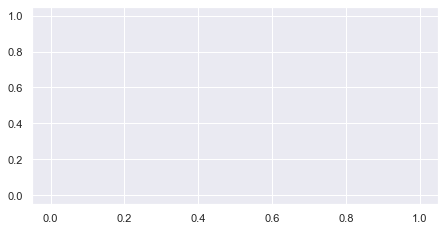

In [22]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

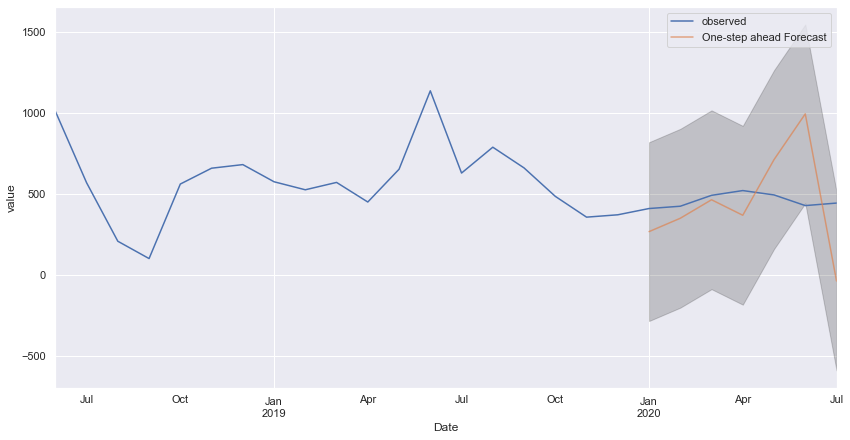

In [23]:
#предсказания с начала 2020 и сравнение с рельными данными
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = sample_month['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()

## Оценка ошибки

In [24]:
sample_month_forecasted = pred.predicted_mean
sample_month_truth = sample_month['2020-01-01':]
mse = ((sample_month_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

NameError: name 'y_truth' is not defined

In [25]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

NameError: name 'mse' is not defined

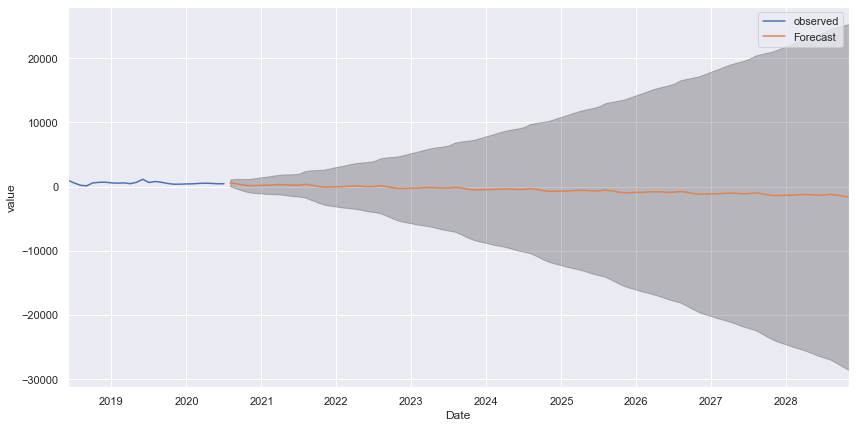

In [26]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = sample_month.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('value')
plt.legend()
plt.show()